In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import os
import torchvision
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

import pickle

plt.style.use('dark_background')

print(f"{'Pytorch':<20}",torch.__version__)
if torch.cuda.is_available():
    device='cuda'

    print(f"{'Device':<20}", f"GPU ({torch.cuda.get_device_name(0)})")
    
    torch.backends.cudnn.benchmark = True
else:
    print("GPU is **not available**")
    device='cpu'

Pytorch              1.10.2+cu102
GPU is **not available**


/home/addy/pytorch/torch-venv/lib/python3.8/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
data_dir = pathlib.Path('/home/addy/datasets/pets_photos/')

if data_dir.exists():
    print("Found the 'pets_photos' dataset.")
else:
    print("Downloading the 'pets_photos' dataset.")
    dataset_url = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
    # !wget {dataset_url} -P {data_dir.parent}
    # !mkdir {data_dir}
    # !tar xf {data_dir.parent / "images.tar.gz"} -C {data_dir}
    
    # Move cats and dogs into their own subfolder so that the 
    # tf.keras.utils.image_dataset_from_directory function can pickup
    # categories from the folder structure.

    images_dir = data_dir / 'images'
    cats_dir = data_dir / 'cats'
    dogs_dir = data_dir / 'dogs'

    cats_dir.mkdir()
    dogs_dir.mkdir()

    f = []
    for (dirpath, dirnames, filenames) in os.walk(images_dir):
        for file in filenames:
            # The cats' image filenames start with an uppercase letter ¯\_(ツ)_/¯
            if file[0].isupper():
                os.rename(images_dir / file, cats_dir / file)
            else:
                os.rename(images_dir / file, dogs_dir / file)


    # Finally delete the images folder. All photos should be under 
    # their proper categorical folder.
    !rm -r {data_dir / 'images'}


Found the 'pets_photos' dataset.


In [3]:
seed = 120
batch_size = 32

image_height = 160
image_width = 160

In [4]:
transform_image = torchvision.transforms.Compose([
    torchvision.transforms.Resize([image_height, image_width]),
    torchvision.transforms.ToTensor()
])

transform_label = lambda x: torch.tensor(float(x)).unsqueeze(-1)

dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=transform_image,
    target_transform=transform_label
)

In [5]:
len_train = int(len(dataset) * 0.8)
len_test = len(dataset) - len_train

train_dataset, test_dataset = random_split(
    dataset, [len_train, len_test], 
    generator=torch.Generator().manual_seed(seed)    )
train_dataset, test_dataset


(<torch.utils.data.dataset.Subset at 0x7fdd30065400>,
 <torch.utils.data.dataset.Subset at 0x7fdd30065d90>)

In [6]:
def collate_fn(batch):    
    elem = batch[0]
    elem_type = type(elem)
    print(elem_type)
    return batch

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=12,
    prefetch_factor=3)

test_dataloader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    num_workers=12,
    prefetch_factor=3)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([32, 3, 160, 160])
Shape of y:  torch.Size([32, 1]) torch.float32


### Displaying pyTorch's img tensor using matplotlib

pyTorch reads img files into a tensor of shape `[3, 160, 160]`. However, `matplotlib` expects the shape to be in `[160,160,3]` and will throw the exception `TypeError: Invalid shape (3, 160, 240) for image data` if called directly.

In [7]:
class_names = dataset.classes

In [8]:
for X, y in test_dataloader:
    img = X[0]
    break

img.shape, np.transpose(img.numpy(), (1, 2, 0)).shape

(torch.Size([3, 160, 160]), (160, 160, 3))

Calling `np.transpose(img.numpy(), (1, 2, 0))` returns an array which fits the numpy criteria. 


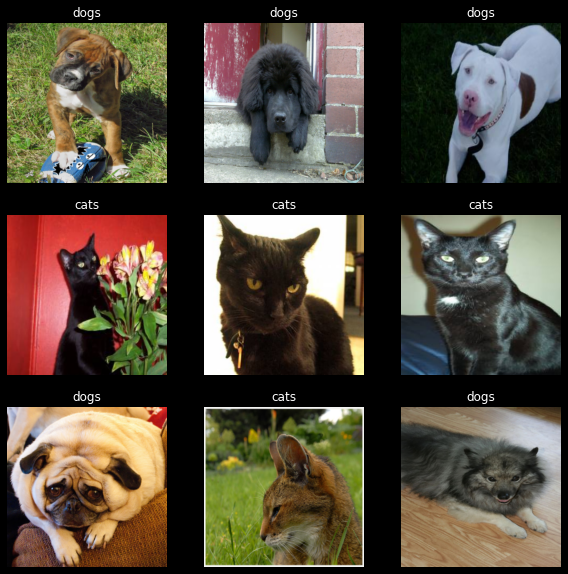

In [9]:
class_names = list(train_dataset.dataset.class_to_idx.keys())

fig = plt.figure(figsize=(10, 10))
for images, labels in train_dataloader:
    for i in range(9):        
        ax = plt.subplot(3, 3, i + 1)
        img = np.transpose(images[i].numpy(), (1, 2, 0))
        plt.imshow(img)
        plt.title(class_names[int(labels[i].item())])
        plt.axis("off")
    break
        

plt.show()


In [10]:
def train_loop(dataloader, model, loss_fn, optimizer, history):
    size = len(dataloader.dataset)
    accuracy = 0
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        
        #FORWARD PASS
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss = loss.item()
        accuracy += (torch.round(pred) == y).type(torch.float).sum().item()

        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    accuracy /= size
    history['train_loss'].append(loss)
    history['train_accuracy'].append(accuracy)
    return loss, accuracy


def test_loop(dataloader, model, loss_fn, history):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, accuracy = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            
            pred = model(X)
            
            loss += loss_fn(pred, y).item()
            accuracy += (torch.round(pred) == y).type(torch.float).sum().item()

    loss /= num_batches
    accuracy /= size

    history['test_loss'].append(loss)
    history['test_accuracy'].append(accuracy)
    return loss, accuracy

In [11]:

import torch.nn as nn
import torch.nn.functional as F

class BinaryNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 81 * 4, 128)
        self.fc2 = nn.Linear(128, 1)
            
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [12]:
model = BinaryNet2().to(device)
    
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

epochs = 10
history = {
    'train_loss':[],
    'train_accuracy':[],
    'test_loss':[],
    'test_accuracy':[]
}

for t in tqdm(range(epochs), bar_format="{elapsed} Elapsed | {percentage:3.0f}% done |{bar}| {n_fmt}/{total_fmt} [{remaining} remaining | {rate_fmt}{postfix}]", unit="epoch", total=epochs):
    train_loop(train_dataloader, model, loss_fn, optimizer, history)
    test_loop(test_dataloader, model, loss_fn, history)

01:56 Elapsed |  10% done |█         | 1/10 [17:29 remaining | 116.65s/epoch]


KeyboardInterrupt: 

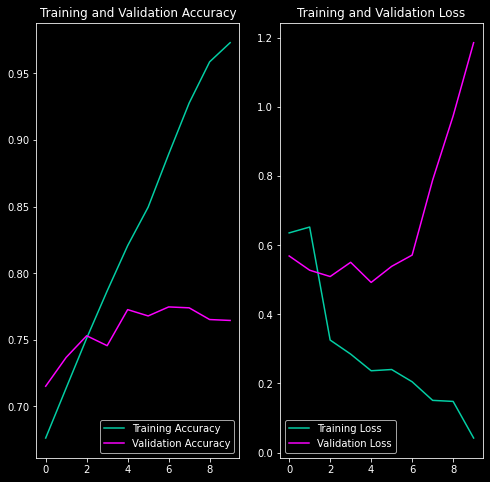

In [ ]:
def plotTrainingGraphs(history):
    epochs_range = range(len(history['train_accuracy']))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history['train_accuracy'], label='Training Accuracy', color='#03CEA4')
    plt.plot(epochs_range, history['test_accuracy'], label='Validation Accuracy', color='#fc00ff')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history['train_loss'], label='Training Loss', color='#03CEA4')
    plt.plot(epochs_range, history['test_loss'], label='Validation Loss', color='#fc00ff')
    plt.legend(loc='lower left')
    plt.title('Training and Validation Loss')
    plt.show()

plotTrainingGraphs(history)
pickle.dump(history, open(pathlib.Path()/'data'/'11-pet-classif-norm1.pkl', 'wb'))


In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class BinaryNet3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.bn = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 81 * 4, 128)
        self.fc2 = nn.Linear(128, 1)
            
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.bn(x)
        x = self.dropout(x)
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [ ]:
model = BinaryNet3().to(device)
    
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

epochs = 10
history = {
    'train_loss':[],
    'train_accuracy':[],
    'test_loss':[],
    'test_accuracy':[]
}

for t in tqdm(range(epochs), bar_format="{elapsed} Elapsed | {percentage:3.0f}% done |{bar}| {n_fmt}/{total_fmt} [{remaining} remaining | {rate_fmt}{postfix}]", unit="epoch", total=epochs):
    train_loop(train_dataloader, model, loss_fn, optimizer, history)
    test_loop(test_dataloader, model, loss_fn, history)

01:09 Elapsed | 100% done |██████████| 10/10 [00:00 remaining |  6.91s/epoch]


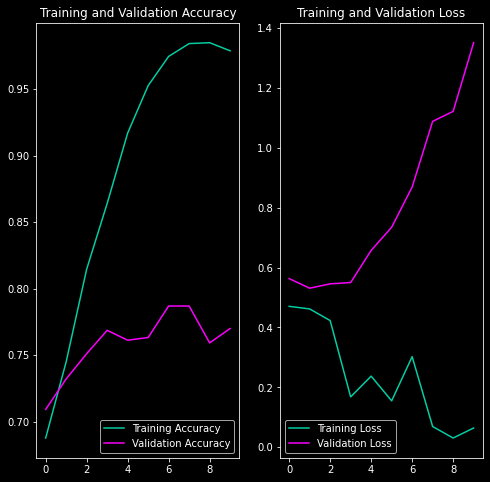

In [ ]:
plotTrainingGraphs(history)
pickle.dump(history, open(pathlib.Path()/'data'/'11-pet-classif-norm2.pkl', 'wb'))